# importing required libraries

In [63]:
import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf

path='C:/Users/ebrah/Desktop/Ryerson/neural_network/project/ct_data'
os.chdir(path)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import shutil
from glob import glob
# Helper libraries
import matplotlib.pyplot as plt
import math
%matplotlib inline
import cv2 # image and video processing library

# Reading input data
Chest CT images are distributed in two files to differentiate Positive Covid Cases from Negative ones. As negative cases include images in 2 different formats(jpg and png), they are imported seperately.

In [64]:
data_root='C:/Users/ebrah/Desktop/Ryerson/neural_network/project/ct_data'
path_positive_cases = os.path.join('C:/Users/ebrah/Desktop/Ryerson/neural_network/project/ct_data/CT_COVID/')
path_negative_cases = os.path.join('C:/Users/ebrah/Desktop/Ryerson/neural_network/project/ct_data/CT_NonCOVID')

positive_images_ls = glob(os.path.join(path_positive_cases,"*.png"))

negative_images_ls = glob(os.path.join(path_negative_cases,"*.png"))
negative_images_ls.extend(glob(os.path.join(path_negative_cases,"*.jpg")))

# Datasets Overview 

There are 349 images with positive covid cases and 397 for negative ones.

In [65]:
total_positive_covid = len(positive_images_ls)
total_negative_covid = len(negative_images_ls)
print("Total Positive Cases Covid19 images: {}".format(total_positive_covid))
print("Total Negative Cases Covid19 images: {}".format(total_negative_covid))

Total Positive Cases Covid19 images: 349
Total Negative Cases Covid19 images: 397


To compare CT images of a positive covid case with negative, they are plotted in a figure.

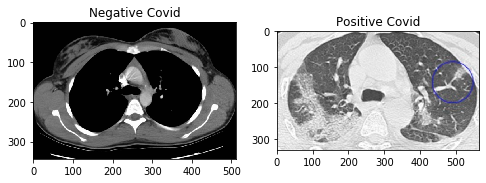

In [66]:
image_positive = cv2.imread(os.path.join(positive_images_ls[1]))
image_negative = cv2.imread(os.path.join(negative_images_ls[5]))

f = plt.figure(figsize=(8, 8))
plt1=f.add_subplot(1, 2, 1)
plt1.title.set_text('Negative Covid')
plt.imshow(image_negative)
plt2=f.add_subplot(1,2, 2)
plt2.title.set_text('Positive Covid')
plt.imshow(image_positive)

In [67]:
# print("Image COVID Shape {}".format(image_positive.shape))
# print("Image Non COVID Shape {}".format(image_negative.shape))

# Creating Directories for Train and Test Data 

In [68]:
# Create Train-Test Directory
subdirs  = ['train/', 'test/']
for subdir in subdirs:
    labeldirs = ['CT_COVID', 'CT_NonCOVID']
    for labldir in labeldirs:
        newdir = subdir + labldir
        os.makedirs(newdir, exist_ok=True)

In [69]:
# Copy Images to test set

# seed random number generator
random.seed(123)
# ratio of pictures used for testing 
test_ratio = 0.2

covid = {'class': 'CT_COVID',
         'path': path_positive_cases,
         'images': positive_images_ls}

non_covid = {'class': 'CT_NonCOVID',
             'path': path_negative_cases,
             'images': negative_images_ls}

for cases in [covid, non_covid]:
    total_cases = len(cases['images']) #number of total images
    num_to_select = int(test_ratio * total_cases) #number of images to copy to test set
    
    print( num_to_select, cases['class'],' are selected for test.')
    
    list_of_random_files = random.sample(cases['images'], num_to_select) #random files selected

    for files in list_of_random_files:
        shutil.copy2(files, 'test/' + cases['class'])

69 CT_COVID  are selected for test.
79 CT_NonCOVID  are selected for test.


In [70]:
# Copy Images to train set
for cases in [covid, non_covid]:
    image_test_files = os.listdir('test/' + cases['class']) # list test files 
    for images in cases['images']:
        if images.split('/')[-1] not in (image_test_files): #exclude test files from shutil.copy
            shutil.copy2(images, 'train/' + cases['class'])

In [71]:
total_train_covid = len(os.listdir('C:/Users/ebrah/Desktop/Ryerson/neural_network/project/ct_data/train/CT_COVID'))
total_train_noncovid = len(os.listdir('C:/Users/ebrah/Desktop/Ryerson/neural_network/project/ct_data/train/CT_NonCOVID'))
total_test_covid = len(os.listdir('C:/Users/ebrah/Desktop/Ryerson/neural_network/project/ct_data/test/CT_COVID'))
total_test_noncovid = len(os.listdir('C:/Users/ebrah/Desktop/Ryerson/neural_network/project/ct_data/test/CT_NonCOVID'))

print("Train sets images COVID: {}".format(total_train_covid))
print("Train sets images Non COVID: {}".format(total_train_noncovid))
print("Test sets images COVID: {}".format(total_test_covid))
print("Test sets images Non COVID: {}".format(total_test_noncovid))

Train sets images COVID: 349
Train sets images Non COVID: 397
Test sets images COVID: 69
Test sets images Non COVID: 79


# Creating CNN Model


In [72]:
batch_size = 128
epochs = 15

In [73]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [74]:
train_dir = os.path.join('C:/Users/ebrah/Neural network project/train')
test_dir = os.path.join('C:/Users/ebrah/Neural network project/test')


total_train = total_train_covid + total_train_noncovid
total_test = total_test_covid + total_test_noncovid

In [75]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 746 images belonging to 2 classes.


In [76]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 176 images belonging to 2 classes.


In [77]:
IMG_HEIGHT = 150
IMG_WIDTH = 150
channels=3 

model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,channels)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    #Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(1)
])

In [78]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [79]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 20736)            

In [80]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=test_data_gen,
    validation_steps=total_test // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 1 steps
Epoch 1/15
5/5 [==============================] - 11s 2s/step - loss: 2.7784 - accuracy: 0.4790 - val_loss: 1.3901 - val_accuracy: 0.3984
Epoch 2/15
5/5 [==============================] - 10s 2s/step - loss: 0.8666 - accuracy: 0.4434 - val_loss: 0.6709 - val_accuracy: 0.4062
Epoch 3/15
5/5 [==============================] - 10s 2s/step - loss: 0.6878 - accuracy: 0.5065 - val_loss: 0.6463 - val_accuracy: 0.4688
Epoch 4/15
5/5 [==============================] - 9s 2s/step - loss: 0.6516 - accuracy: 0.5259 - val_loss: 0.6214 - val_accuracy: 0.6484
Epoch 5/15
5/5 [==============================] - 9s 2s/step - loss: 0.6443 - accuracy: 0.5550 - val_loss: 0.5978 - val_accuracy: 0.5312
Epoch 6/15
5/5 [==============================] - 9s 2s/step - loss: 0.5954 - accuracy: 0.6570 - val_loss: 0.5514 - val_accuracy: 0.6250
Epoch 7/15
5/5 [==============================] - 9s 2s/step - loss: 0.5500 - accurac

# Measuring model performance

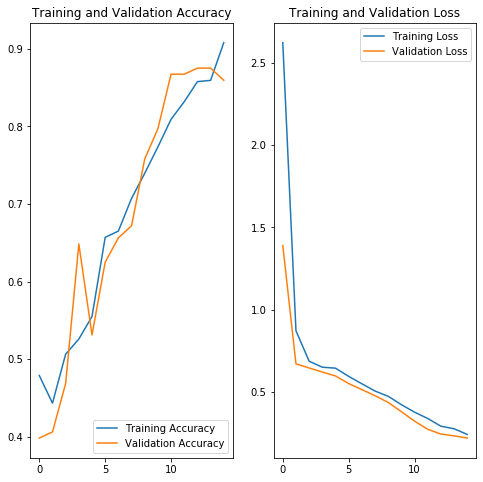

In [81]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()